## DATA

* 한국 석유 공사, 오피넷에서 제공하는 국내 유가 데이터로 지역별 주유소 평균 판매가격(부가세 포함) 데이터를 활용하였습니다. 
* 오피넷에서 전지역의 데이터를 제공하지만 본 데이터는 경남지역의 2008년 4월 15일부터 2019년 11월 12일의 일간 시계열 데이터입니다.

   http://www.opinet.co.kr/user/dopospdrg/dopOsPdrgAreaView.do

## ANALYSIS

* 데이터는 Train data 80% Test data 20%로 분할하여 분석을 진행.
* LSTM과 GRU모델 중 GRU 모델만을 사용하여 Ensemble을 진행.
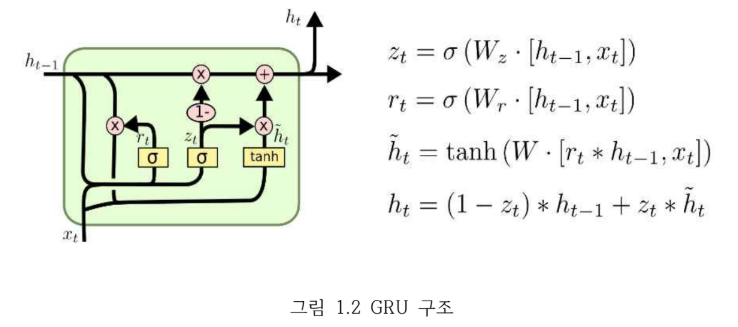

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import GRU
from keras.layers import Dropout
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time

Using TensorFlow backend.
C:\Users\K.N.W\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\K.N.W\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\K.N.W\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\K.N.W\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
# 같은 결과를 나오게 하기 위해 seed 설정
np.random.seed(111)

In [4]:
import tensorflow as tf
import keras

config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

### 데이터 불러오기

In [5]:
import datetime
from datetime import date

In [6]:
dataset = pd.read_csv(r'region_daily_new.csv', encoding = 'EUC-KR')  

In [7]:
index = dataset['Date']

In [8]:
for i in range(len(index)):
    index[i] = datetime.datetime.strptime(index[i], "%Y년%m월%d일").date()

C:\Users\K.N.W\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
dataset.head()

,Date,Gyeongnam
0,2008-04-15,1674.62
1,2008-04-16,1680.75
2,2008-04-17,1679.82
3,2008-04-18,1681.93
4,2008-04-19,1685.71


In [10]:
dataset2 = dataset.set_index("Date")

In [11]:
dataset2.head()

,Gyeongnam
Date,
2008-04-15,1674.62
2008-04-16,1680.75
2008-04-17,1679.82
2008-04-18,1681.93
2008-04-19,1685.71


C:\Users\K.N.W\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


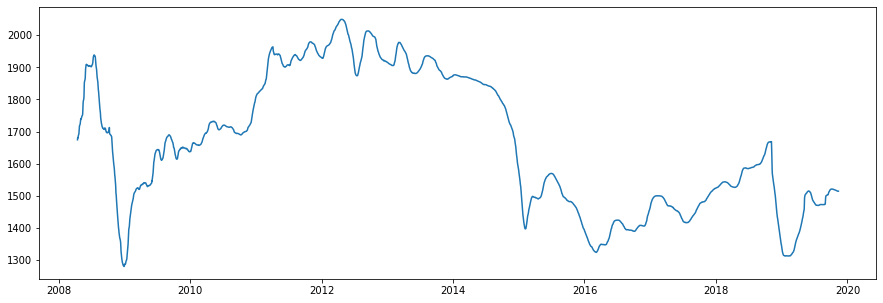

In [12]:
# 원본 데이터 보기
plt.figure(figsize = (15, 5))
plt.plot(dataset2)
plt.show()

In [13]:
# 필요한 부분만 불러오기
dataset = dataset.iloc[:, 1:2].values  

In [14]:
# scikit-learn 라이브러리 의 MinMaxScaler 전처리 클래스를 사용하여 데이터 세트를 쉽게 정규화.
# MinMaxScaler을 통해 데이터를 비례적으로 조정

scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

In [15]:
dataset

array([[ 0.02523458],
       [ 0.04119002],
       [ 0.03876937],
       ...,
       [-0.39098635],
       [-0.39127266],
       [-0.39072606]])

In [16]:
data_df = pd.DataFrame(dataset, columns=['price'], index=index)
data_df.head()

,price
Date,
2008-04-15,0.025235
2008-04-16,0.041190
2008-04-17,0.038769
2008-04-18,0.044261
2008-04-19,0.054100


### 데이터 분할

1. Training Data : 3383개 (80%)

    Test Data : 846개 (20%)



2. 10일치 데이터로 7일 뒤 예측

In [17]:
row = int(round(dataset.shape[0] * 0.8))
train_df = data_df[:row]
test_df = data_df[row:]

In [18]:
row

3383

In [19]:
for s in range(1, 11):
    train_df['shift_{}'.format(s)] = train_df['price'].shift(s+7)
    test_df['shift_{}'.format(s)] = test_df['price'].shift(s+7)

train_df.head(19)

C:\Users\K.N.W\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\K.N.W\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,price,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,,
2008-04-15,0.025235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-16,0.041190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-17,0.038769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-18,0.044261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-19,0.054100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-20,0.059748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-21,0.063965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-22,0.069769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-23,0.078463,0.025235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
X_train = train_df.dropna().drop('price', axis=1)
y_train = train_df.dropna()[['price']]

X_test = test_df.dropna().drop('price', axis=1)
y_test = test_df.dropna()[['price']]


In [21]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,
2008-05-02,0.098505,0.078463,0.069769,0.063965,0.059748,0.054100,0.044261,0.038769,0.041190,0.025235
2008-05-03,0.121019,0.098505,0.078463,0.069769,0.063965,0.059748,0.054100,0.044261,0.038769,0.041190
2008-05-04,0.138042,0.121019,0.098505,0.078463,0.069769,0.063965,0.059748,0.054100,0.044261,0.038769
2008-05-05,0.140645,0.138042,0.121019,0.098505,0.078463,0.069769,0.063965,0.059748,0.054100,0.044261
2008-05-06,0.144809,0.140645,0.138042,0.121019,0.098505,0.078463,0.069769,0.063965,0.059748,0.054100


In [22]:
y_train.head()

,price
Date,
2008-05-02,0.179349
2008-05-03,0.192519
2008-05-04,0.190541
2008-05-05,0.193456
2008-05-06,0.197777


In [23]:
X_train_values = X_train.values
X_test_values= X_test.values

y_train_values = y_train.values
y_test_values = y_test.values
print(X_train_values.shape)
print(X_train_values)
print(y_train_values.shape)
print(y_train_values)


(3366, 10)
[[ 0.09850467  0.07846276  0.06976926 ...  0.03876937  0.04119002
   0.02523458]
 [ 0.12101927  0.09850467  0.07846276 ...  0.04426138  0.03876937
   0.04119002]
 [ 0.13804188  0.12101927  0.09850467 ...  0.05410013  0.04426138
   0.03876937]
 ...
 [-0.64231705 -0.64114577 -0.63966215 ... -0.63323312 -0.63141113
  -0.62537253]
 [-0.64307188 -0.64231705 -0.64114577 ... -0.634951   -0.63323312
  -0.63141113]
 [-0.64255131 -0.64307188 -0.64231705 ... -0.63596611 -0.634951
  -0.63323312]]
(3366, 1)
[[ 0.17934903]
 [ 0.19251942]
 [ 0.19054126]
 ...
 [-0.64557061]
 [-0.64463358]
 [-0.6449199 ]]


In [24]:
X_train_t = X_train_values.reshape(X_train_values.shape[0], 10, 1)
X_test_t = X_test_values.reshape(X_test_values.shape[0], 10, 1)

print("최종 GRU DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train_values)


최종 GRU DATA
(3366, 10, 1)
[[[ 0.09850467]
  [ 0.07846276]
  [ 0.06976926]
  ...
  [ 0.03876937]
  [ 0.04119002]
  [ 0.02523458]]

 [[ 0.12101927]
  [ 0.09850467]
  [ 0.07846276]
  ...
  [ 0.04426138]
  [ 0.03876937]
  [ 0.04119002]]

 [[ 0.13804188]
  [ 0.12101927]
  [ 0.09850467]
  ...
  [ 0.05410013]
  [ 0.04426138]
  [ 0.03876937]]

 ...

 [[-0.64231705]
  [-0.64114577]
  [-0.63966215]
  ...
  [-0.63323312]
  [-0.63141113]
  [-0.62537253]]

 [[-0.64307188]
  [-0.64231705]
  [-0.64114577]
  ...
  [-0.634951  ]
  [-0.63323312]
  [-0.63141113]]

 [[-0.64255131]
  [-0.64307188]
  [-0.64231705]
  ...
  [-0.63596611]
  [-0.634951  ]
  [-0.63323312]]]
[[ 0.17934903]
 [ 0.19251942]
 [ 0.19054126]
 ...
 [-0.64557061]
 [-0.64463358]
 [-0.6449199 ]]


## MODEL

#### GRU 모델의 Activation은 linear, Optimizer은 adam으로 고정하고 layer의 변경을 통해 모델 5개를 생성하였다.

## MODEL1

- layer층의 크기가 128인 단일 GRU MODEL 

In [25]:
pred_list1 = []

start = time.time()

for i in range(10):
    model1 = Sequential()
    model1.add(GRU(128, input_shape=(10, 1)))
    model1.add(Dense(1, activation='linear'))
    model1.compile(loss='mse', optimizer='adam')
    
    model1.fit(X_train_t, y_train, batch_size=10, epochs=30)
    y_pred1 = model1.predict(X_test_t)
    pred_list1.append(y_pred1)
    
end = time.time()
total = end-start
print(total)


Epoch 1/30
3366/3366 [==============================] - 3s 878us/step - loss: 0.0101
Epoch 2/30
3366/3366 [==============================] - 2s 739us/step - loss: 0.0052
Epoch 3/30
3366/3366 [==============================] - 2s 742us/step - loss: 0.0046
Epoch 4/30
3366/3366 [==============================] - 3s 761us/step - loss: 0.0045
Epoch 5/30
3366/3366 [==============================] - 3s 761us/step - loss: 0.0034
Epoch 6/30
3366/3366 [==============================] - 3s 778us/step - loss: 0.0032
Epoch 7/30
3366/3366 [==============================] - 3s 812us/step - loss: 0.0022
Epoch 8/30
3366/3366 [==============================] - 3s 798us/step - loss: 0.0021
Epoch 9/30
3366/3366 [==============================] - 3s 789us/step - loss: 0.0017
Epoch 10/30
3366/3366 [==============================] - 3s 777us/step - loss: 0.0017
Epoch 11/30
3366/3366 [==============================] - 3s 754us/step - loss: 0.0014
Epoch 12/30
3366/3366 [==============================] - 3s 76

Epoch 4/30
3366/3366 [==============================] - 3s 755us/step - loss: 0.0036
Epoch 5/30
3366/3366 [==============================] - 3s 764us/step - loss: 0.0033
Epoch 6/30
3366/3366 [==============================] - 3s 771us/step - loss: 0.0025
Epoch 7/30
3366/3366 [==============================] - 3s 771us/step - loss: 0.0024
Epoch 8/30
3366/3366 [==============================] - 3s 769us/step - loss: 0.0018
Epoch 9/30
3366/3366 [==============================] - 3s 812us/step - loss: 0.0019
Epoch 10/30
3366/3366 [==============================] - 3s 786us/step - loss: 0.0019
Epoch 11/30
3366/3366 [==============================] - 3s 775us/step - loss: 0.0014
Epoch 12/30
3366/3366 [==============================] - 3s 776us/step - loss: 0.0017
Epoch 13/30
3366/3366 [==============================] - 3s 753us/step - loss: 0.0015
Epoch 14/30
3366/3366 [==============================] - 3s 775us/step - loss: 0.0015
Epoch 15/30
3366/3366 [==============================] - 3s 

3366/3366 [==============================] - 2s 676us/step - loss: 0.0012
Epoch 15/30
3366/3366 [==============================] - 2s 673us/step - loss: 0.0015
Epoch 16/30
3366/3366 [==============================] - 2s 679us/step - loss: 0.0011
Epoch 17/30
3366/3366 [==============================] - 2s 680us/step - loss: 0.0011
Epoch 18/30
3366/3366 [==============================] - 2s 705us/step - loss: 0.0011
Epoch 19/30
3366/3366 [==============================] - 2s 679us/step - loss: 0.0012
Epoch 20/30
3366/3366 [==============================] - 2s 670us/step - loss: 0.0011
Epoch 21/30
3366/3366 [==============================] - 2s 674us/step - loss: 0.0012
Epoch 22/30
3366/3366 [==============================] - 2s 675us/step - loss: 9.9567e-04
Epoch 23/30
3366/3366 [==============================] - 2s 674us/step - loss: 0.0011
Epoch 24/30
3366/3366 [==============================] - 2s 672us/step - loss: 0.0010
Epoch 25/30
3366/3366 [==============================] - 2s 67

<function matplotlib.pyplot.show(*args, **kw)>

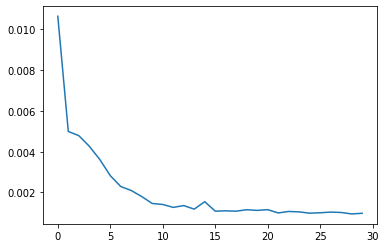

In [26]:
plt.plot(model1.history.history['loss'])
plt.show

In [27]:
MSE1 = []
l_RMSE1 = []
l_MAE1 = []

for y in range(10):
    mse = mean_squared_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list1[y]))
    MSE1.append(mse)
    l_RMSE1.append(math.sqrt(mse))
    l_MAE1.append(mean_absolute_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list1[y])))
    
    print('MSE : ', MSE1[y], '\nRMSE : ', l_RMSE1[y], '\nMAE : ', l_MAE1[y]) 

MSE :  287.9069208824181 
RMSE :  16.967820157062548 
MAE :  11.603869031070952
MSE :  217.23753591306448 
RMSE :  14.738980151729104 
MAE :  7.8873647832007725
MSE :  248.01238235140949 
RMSE :  15.74840888316688 
MAE :  9.800143132963292
MSE :  236.12326130124836 
RMSE :  15.366302785681674 
MAE :  9.723058902386152
MSE :  326.3899510017692 
RMSE :  18.066265552176773 
MAE :  13.937729038657261
MSE :  313.24985574815656 
RMSE :  17.698865945256397 
MAE :  13.32282151759461
MSE :  198.8937354273091 
RMSE :  14.102969028800606 
MAE :  6.767355712596117
MSE :  216.67068394639068 
RMSE :  14.71973790345435 
MAE :  8.023615378091069
MSE :  240.9925195901397 
RMSE :  15.523933766611467 
MAE :  9.202760950693602
MSE :  198.9148130893986 
RMSE :  14.103716286475652 
MAE :  6.713967476581343


In [28]:
npred_list1 = []

for j in range(len(pred_list1[0])):
    npred_list1.append([np.mean([pred_list1[0][j], pred_list1[1][j], pred_list1[2][j], 
                                pred_list1[3][j], pred_list1[4][j], pred_list1[5][j],
                                pred_list1[6][j], pred_list1[7][j], pred_list1[8][j],
                                pred_list1[9][j]])])
    
npred_list1 = np.array(npred_list1)

In [29]:
trainPredict = model1.predict(X_train_t)
trainPredict = scaler.inverse_transform(trainPredict) 

testPredict = scaler.inverse_transform(npred_list1)
Ydata = scaler.inverse_transform(y_test)

testPredict_df = pd.DataFrame(testPredict, columns=['price'], index=y_test.index)
testPredict_df.head()

,price
Date,
2017-08-06,1416.530762
2017-08-07,1416.640503
2017-08-08,1417.020630
2017-08-09,1417.721069
2017-08-10,1418.446533


In [30]:
Ydata_df = pd.DataFrame(Ydata, columns=['price'], index=y_test.index)
Ydata_df.head()

,price
Date,
2017-08-06,1421.09
2017-08-07,1421.84
2017-08-08,1422.82
2017-08-09,1423.53
2017-08-10,1424.54


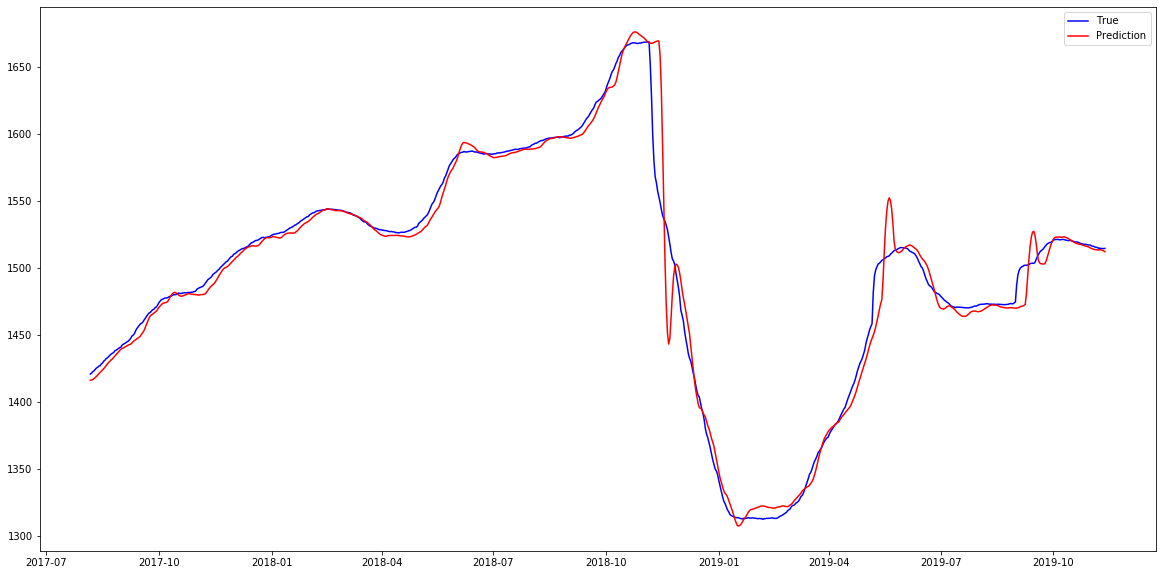

In [31]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata_df, label='True', color = 'Blue')
ax.plot(testPredict_df, label='Prediction', color='Red')
ax.legend()
plt.show()

## MODEL2

- layer층의 크기가 256인 단일 GRU MODEL 

In [32]:
pred_list2 = []

start = time.time()

for i in range(10):
    model2 = Sequential()
    model2.add(GRU(256, input_shape=(10, 1)))
    model2.add(Dense(1, activation='linear'))
    model2.compile(loss='mse', optimizer='adam')

    model2.fit(X_train_t, y_train, batch_size=10, epochs=30)
    y_pred2 = model2.predict(X_test_t)
    pred_list2.append(y_pred2)
    
end = time.time()
total = end-start
print(total)

Epoch 1/30
3366/3366 [==============================] - 8s 2ms/step - loss: 0.0077A
Epoch 2/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0016
Epoch 12/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0018
Epoch 13/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0014
Epoch 14/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0013
Epoch 15/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0014
Epoch 16/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0012
Epoch 17/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0011
Epoch 27/30
3366/3366 [==============================] - 7s 2ms/step - loss: 9.9326e-04
Epoch 28/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0010
Epoch 29/30
3366/3366 [==============================] - 7s 2ms/step - loss: 0.0010
Epoch 30/30
3366/3366 [==============================] - 7s 2ms/step - lo

3366/3366 [==============================] - 8s 2ms/step - loss: 0.0012
Epoch 25/30
3366/3366 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 26/30
3366/3366 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 27/30
3366/3366 [==============================] - 8s 2ms/step - loss: 9.3497e-04
Epoch 28/30
3366/3366 [==============================] - 8s 2ms/step - loss: 8.8986e-04
Epoch 29/30
3366/3366 [==============================] - 8s 2ms/step - loss: 8.9476e-04
Epoch 30/30
3366/3366 [==============================] - 8s 2ms/step - loss: 9.3167e-04
Epoch 1/30
3366/3366 [==============================] - 9s 3ms/step - loss: 0.0094
Epoch 2/30
3366/3366 [==============================] - 8s 2ms/step - loss: 0.0053
Epoch 3/30
3366/3366 [==============================] - 8s 2ms/step - loss: 0.0046
Epoch 4/30
3366/3366 [==============================] - 8s 2ms/step - loss: 0.0046
Epoch 5/30
3366/3366 [==============================] - 8s 2ms/step - loss: 

<function matplotlib.pyplot.show(*args, **kw)>

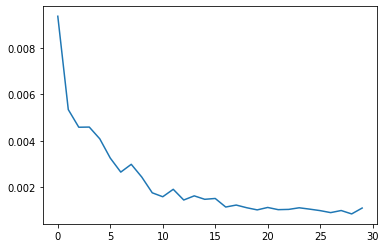

In [33]:
plt.plot(model2.history.history['loss'])
plt.show

In [34]:
MSE2 = []
l_RMSE2 = []
l_MAE2 = []

for y in range(10):
    mse = mean_squared_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list2[y]))
    MSE2.append(mse)
    l_RMSE2.append(math.sqrt(mse))
    l_MAE2.append(mean_absolute_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list2[y])))
    
    print('MSE : ', MSE2[y], '\nRMSE : ', l_RMSE2[y], '\nMAE : ', l_MAE2[y]) 

MSE :  197.5189515426958 
RMSE :  14.054143572010917 
MAE :  7.552742685794248
MSE :  179.8753823924336 
RMSE :  13.411762836869492 
MAE :  6.224387875546587
MSE :  277.7527896309057 
RMSE :  16.665917005400743 
MAE :  11.269083833590928
MSE :  180.42526794820535 
RMSE :  13.432247315628363 
MAE :  6.5140452894111815
MSE :  409.59120284726345 
RMSE :  20.238359687664005 
MAE :  16.080180228202266
MSE :  215.70271840944983 
RMSE :  14.686821249319058 
MAE :  9.655763562320939
MSE :  371.97811329131923 
RMSE :  19.28673412714862 
MAE :  15.91587626752864
MSE :  202.20469624102822 
RMSE :  14.219869768778764 
MAE :  7.818963577399358
MSE :  424.6414725180501 
RMSE :  20.60683072473907 
MAE :  16.50110000518321
MSE :  203.19536305021953 
RMSE :  14.254661099100867 
MAE :  7.138420801841455


In [35]:
npred_list2 = []

for j in range(len(pred_list2[0])):
    npred_list2.append([np.mean([pred_list2[0][j], pred_list2[1][j], pred_list2[2][j], 
                                pred_list2[3][j], pred_list2[4][j], pred_list2[5][j],
                                pred_list2[6][j], pred_list2[7][j], pred_list2[8][j],
                                pred_list2[9][j]])])
    
npred_list2 = np.array(npred_list2)

In [36]:
trainPredict = model2.predict(X_train_t)
trainPredict = scaler.inverse_transform(trainPredict) 

testPredict = scaler.inverse_transform(npred_list2)
Ydata = scaler.inverse_transform(y_test)

testPredict_df = pd.DataFrame(testPredict, columns=['price'], index=y_test.index)
testPredict_df.head()

,price
Date,
2017-08-06,1418.066162
2017-08-07,1418.214478
2017-08-08,1418.708740
2017-08-09,1419.548706
2017-08-10,1420.269897


In [37]:
Ydata_df = pd.DataFrame(Ydata, columns=['price'], index=y_test.index)
Ydata_df.head()

,price
Date,
2017-08-06,1421.09
2017-08-07,1421.84
2017-08-08,1422.82
2017-08-09,1423.53
2017-08-10,1424.54


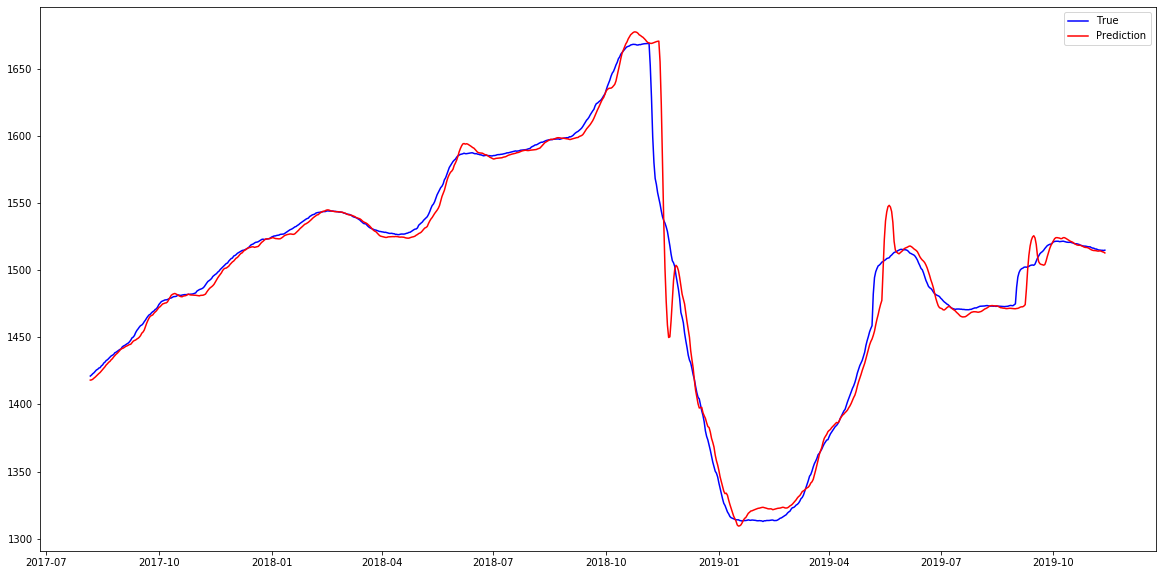

In [38]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata_df, label='True', color = 'Blue')
ax.plot(testPredict_df, label='Prediction', color='Red')
ax.legend()
plt.show()

## MODEL3

- layer층의 크기가 256, 128인 Stacked GRU MODEL 

In [39]:
pred_list3 = []

start = time.time()

for i in range(10):
    model3 = Sequential()
    model3.add(GRU(256, return_sequences=True, input_shape=(10, 1)))
    model3.add(GRU(128, input_shape=(10, 1)))
    model3.add(Dense(1, activation='linear'))
    model3.compile(loss='mse', optimizer='adam')

    model3.fit(X_train_t, y_train, batch_size=10, epochs=30)
    y_pred3 = model3.predict(X_test_t)
    pred_list3.append(y_pred3)
    
end = time.time()
total = end-start
print(total)

Epoch 1/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0082
Epoch 2/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0053
Epoch 3/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0049
Epoch 4/30
3366/3366 [==============================] - 13s 4ms/step - loss: 0.0037
Epoch 5/30
3366/3366 [==============================] - 13s 4ms/step - loss: 0.0035
Epoch 6/30
3366/3366 [==============================] - 13s 4ms/step - loss: 0.0022
Epoch 7/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0024
Epoch 8/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0017
Epoch 9/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0019
Epoch 10/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0022
Epoch 11/30
3366/3366 [==============================] - 12s 4ms/step - loss: 0.0018
Epoch 12/30
3366/3366 [==============================] - 12s 4ms/step - lo

3366/3366 [==============================] - 16s 5ms/step - loss: 0.0017
Epoch 14/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0015
Epoch 15/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0014
Epoch 16/30
3366/3366 [==============================] - 17s 5ms/step - loss: 0.0015
Epoch 17/30
3366/3366 [==============================] - 17s 5ms/step - loss: 0.0015
Epoch 18/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0013
Epoch 19/30
3366/3366 [==============================] - 17s 5ms/step - loss: 0.0014
Epoch 20/30
3366/3366 [==============================] - 17s 5ms/step - loss: 0.0014
Epoch 21/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0014
Epoch 22/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0013
Epoch 23/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0013
Epoch 24/30
3366/3366 [==============================] - 16s 5ms/step - loss:

<function matplotlib.pyplot.show(*args, **kw)>

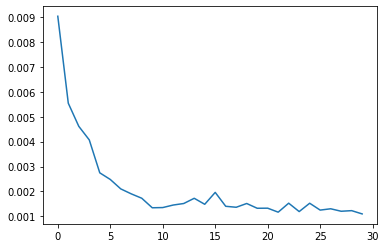

In [40]:
plt.plot(model3.history.history['loss'])
plt.show

In [41]:
MSE3 = []
l_RMSE3 = []
l_MAE3 = []

for y in range(10):
    mse = mean_squared_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list3[y]))
    MSE3.append(mse)
    l_RMSE3.append(math.sqrt(mse))
    l_MAE3.append(mean_absolute_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list3[y])))
    
    print('MSE : ', MSE3[y], '\nRMSE : ', l_RMSE3[y], '\nMAE : ', l_MAE3[y]) 

MSE :  224.99467671955367 
RMSE :  14.999822556268914 
MAE :  7.293234230105921
MSE :  264.0883898519599 
RMSE :  16.250796591304685 
MAE :  8.889022983969767
MSE :  226.8440554534 
RMSE :  15.061343082653684 
MAE :  7.338948593231678
MSE :  240.36092286271327 
RMSE :  15.503577743950371 
MAE :  7.62711742663412
MSE :  474.8149097567093 
RMSE :  21.790248042569623 
MAE :  17.049955654167302
MSE :  308.57020371826235 
RMSE :  17.566166449122083 
MAE :  11.771500060078024
MSE :  309.19326570436994 
RMSE :  17.583892222837637 
MAE :  12.279989403884567
MSE :  492.9387843117165 
RMSE :  22.202224760408956 
MAE :  18.09461334486204
MSE :  239.04956587561566 
RMSE :  15.461227825616426 
MAE :  7.183950961012892
MSE :  246.69607164089936 
RMSE :  15.706561420021231 
MAE :  8.247658246711023


In [42]:
npred_list3 = []

for j in range(len(pred_list3[0])):
    npred_list3.append([np.mean([pred_list3[0][j], pred_list3[1][j], pred_list3[2][j], 
                                pred_list3[3][j], pred_list3[4][j], pred_list3[5][j],
                                pred_list3[6][j], pred_list3[7][j], pred_list3[8][j],
                                pred_list3[9][j]])])
    
npred_list3 = np.array(npred_list3)

In [43]:
trainPredict = model1.predict(X_train_t)
trainPredict = scaler.inverse_transform(trainPredict) 

testPredict = scaler.inverse_transform(npred_list3)
Ydata = scaler.inverse_transform(y_test)

testPredict_df = pd.DataFrame(testPredict, columns=['price'], index=y_test.index)
testPredict_df.head()

,price
Date,
2017-08-06,1422.604004
2017-08-07,1422.747559
2017-08-08,1423.011597
2017-08-09,1423.447754
2017-08-10,1424.117188


In [44]:
Ydata_df = pd.DataFrame(Ydata, columns=['price'], index=y_test.index)
Ydata_df.head()

,price
Date,
2017-08-06,1421.09
2017-08-07,1421.84
2017-08-08,1422.82
2017-08-09,1423.53
2017-08-10,1424.54


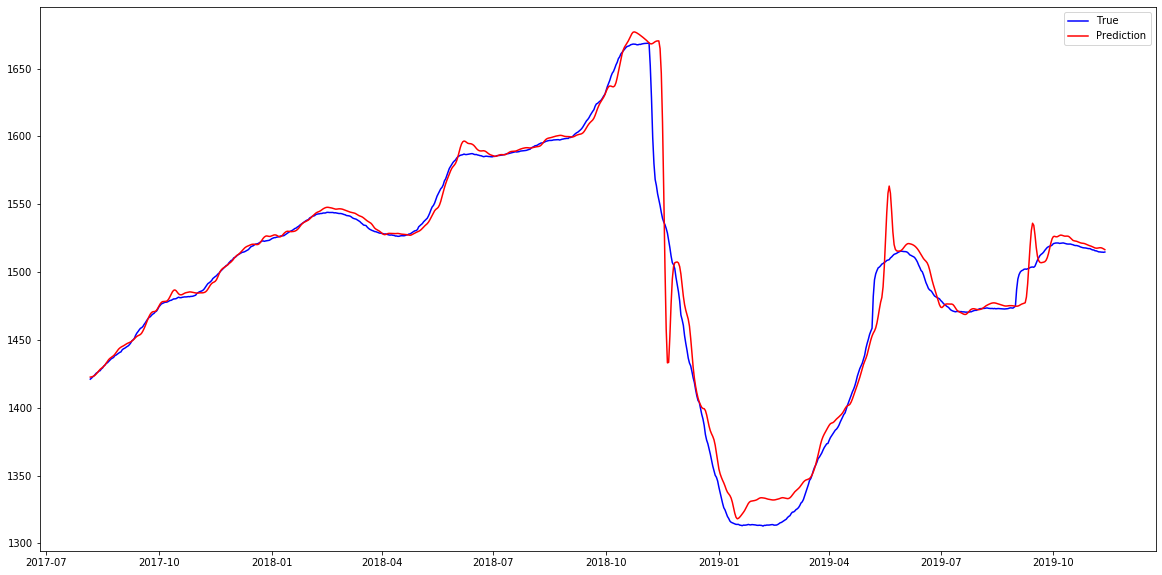

In [45]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata_df, label='True', color = 'Blue')
ax.plot(testPredict_df, label='Prediction', color='Red')
ax.legend()
plt.show()

## MODEL4

- layer층의 크기가 256이고 Dropout층을 포함한 GRU MODEL 

In [46]:
pred_list4 = []

start = time.time()

for i in range(10):
    model4 = Sequential()
    model4.add(GRU(256, input_shape=(10, 1)))
    model4.add(Dropout(0.2))
    model4.add(Dense(1, activation='linear'))
    model4.compile(loss='mse', optimizer='adam')

    model4.fit(X_train_t, y_train, batch_size=10, epochs=30)
    y_pred4 = model4.predict(X_test_t)
    pred_list4.append(y_pred4)
    
end = time.time()
total = end-start
print(total)

Epoch 1/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0108
Epoch 2/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0066
Epoch 3/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0060
Epoch 4/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0051
Epoch 5/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0047
Epoch 6/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0038
Epoch 7/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0039
Epoch 8/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0032
Epoch 9/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0027: 0s - loss: 0.0
Epoch 10/30
3366/3366 [==============================] - 14s 4ms/step - loss: 0.0026
Epoch 11/30
3366/3366 [==============================] - 13s 4ms/step - loss: 0.0023
Epoch 12/30
3366/3366 [==============================] - 1

3366/3366 [==============================] - 16s 5ms/step - loss: 0.0021
Epoch 13/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0022
Epoch 14/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0020 ETA: 0s - l
Epoch 15/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0021: 1s - ETA: 0s - loss: 0.
Epoch 16/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0022
Epoch 17/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0021
Epoch 18/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0019
Epoch 19/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0017
Epoch 20/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0019
Epoch 21/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0017
Epoch 22/30
3366/3366 [==============================] - 16s 5ms/step - loss: 0.0018
Epoch 23/30
3366/3366 [=================

<function matplotlib.pyplot.show(*args, **kw)>

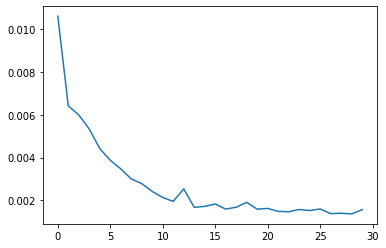

In [47]:
plt.plot(model4.history.history['loss'])
plt.show

In [48]:
MSE4 = []
l_RMSE4 = []
l_MAE4 = []

for y in range(10):
    mse = mean_squared_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list4[y]))
    MSE4.append(mse)
    l_RMSE4.append(math.sqrt(mse))
    l_MAE4.append(mean_absolute_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list4[y])))
    
    print('MSE : ', MSE4[y], '\nRMSE : ', l_RMSE4[y], '\nMAE : ', l_MAE4[y]) 

MSE :  191.15504472737206 
RMSE :  13.825883144572432 
MAE :  7.166915882510936
MSE :  180.5962486073254 
RMSE :  13.438610367419892 
MAE :  6.737012113380198
MSE :  199.33632525555973 
RMSE :  14.11865167980143 
MAE :  7.699348288836326
MSE :  205.44694596334799 
RMSE :  14.333420595355038 
MAE :  7.694510546639401
MSE :  167.11724868481483 
RMSE :  12.927383675160835 
MAE :  6.164073867705814
MSE :  212.87661883277664 
RMSE :  14.590291937887214 
MAE :  9.35691101147843
MSE :  184.8773228904003 
RMSE :  13.596960060631211 
MAE :  6.43408173674985
MSE :  191.6792220019056 
RMSE :  13.844826542860897 
MAE :  6.594503378505722
MSE :  854.4723050580152 
RMSE :  29.23135824860034 
MAE :  26.92841808066005
MSE :  170.01553718348234 
RMSE :  13.039000620579873 
MAE :  6.238401400171513


In [49]:
npred_list4 = []

for j in range(len(pred_list4[0])):
    npred_list4.append([np.mean([pred_list4[0][j], pred_list4[1][j], pred_list4[2][j], 
                                pred_list4[3][j], pred_list4[4][j], pred_list4[5][j],
                                pred_list4[6][j], pred_list4[7][j], pred_list4[8][j],
                                pred_list4[9][j]])])
    
npred_list4 = np.array(npred_list4)

In [50]:
trainPredict = model1.predict(X_train_t)
trainPredict = scaler.inverse_transform(trainPredict) 

testPredict = scaler.inverse_transform(npred_list4)
Ydata = scaler.inverse_transform(y_test)

testPredict_df = pd.DataFrame(testPredict, columns=['price'], index=y_test.index)
testPredict_df.head()

,price
Date,
2017-08-06,1417.964111
2017-08-07,1418.117188
2017-08-08,1418.672363
2017-08-09,1419.494385
2017-08-10,1420.270996


In [51]:
Ydata_df = pd.DataFrame(Ydata, columns=['price'], index=y_test.index)
Ydata_df.head()

,price
Date,
2017-08-06,1421.09
2017-08-07,1421.84
2017-08-08,1422.82
2017-08-09,1423.53
2017-08-10,1424.54


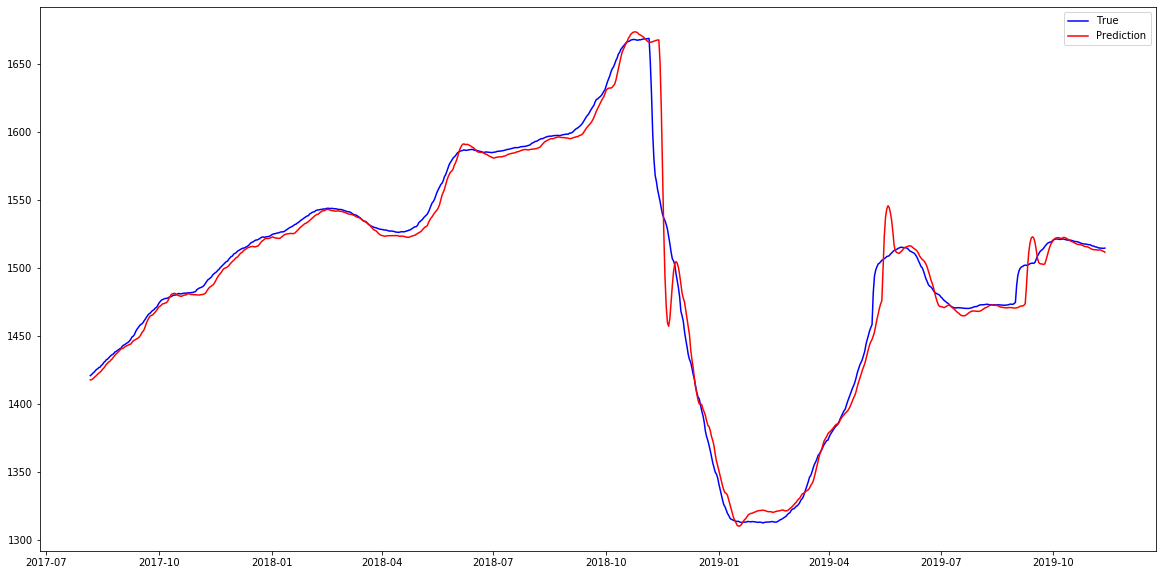

In [52]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata_df, label='True', color = 'Blue')
ax.plot(testPredict_df, label='Prediction', color='Red')
ax.legend()
plt.show()

## MODEL5

- layer층의 크기가 256이고 Dropout층을 포함하고, 층의 크기가 128인 모델을 결합한 GRU MODEL 

In [53]:
pred_list5 = []

start = time.time()

for i in range(10):
    model5 = Sequential()
    model5.add(GRU(256, return_sequences=True, input_shape=(10, 1)))
    model5.add(Dropout(0.2))
    model5.add(GRU(128, input_shape=(10, 1)))
    model5.add(Dense(1, activation='linear'))
    model5.compile(loss='mse', optimizer='adam')

    model5.fit(X_train_t, y_train, batch_size=10, epochs=30)
    y_pred5 = model5.predict(X_test_t)
    pred_list5.append(y_pred5)
    
end = time.time()
total = end-start
print(total)

Epoch 1/30
3366/3366 [==============================] - 34s 10ms/step - loss: 0.0083 3s  - ETA:
Epoch 2/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0056
Epoch 3/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0050
Epoch 4/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0041
Epoch 5/30
3366/3366 [==============================] - ETA: 0s - loss: 0.003 - 31s 9ms/step - loss: 0.0033
Epoch 6/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0036
Epoch 7/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0025: 2s - ETA: 0s - los
Epoch 8/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0023
Epoch 9/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0023
Epoch 10/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0022
Epoch 11/30
3366/3366 [==============================] - 31s 9ms/step - loss: 0.0017
Epoch 12/30
3366/3

3366/3366 [==============================] - 39s 11ms/step - loss: 0.0021
Epoch 10/30
3366/3366 [==============================] - 39s 12ms/step - loss: 0.0021
Epoch 11/30
3366/3366 [==============================] - 39s 11ms/step - loss: 0.0022
Epoch 12/30
3366/3366 [==============================] - 39s 11ms/step - loss: 0.0019
Epoch 13/30
3366/3366 [==============================] - 39s 11ms/step - loss: 0.0019
Epoch 14/30
3366/3366 [==============================] - 39s 12ms/step - loss: 0.0022
Epoch 15/30
3366/3366 [==============================] - 39s 12ms/step - loss: 0.0017
Epoch 16/30
3366/3366 [==============================] - 39s 12ms/step - loss: 0.0016
Epoch 17/30
3366/3366 [==============================] - 39s 12ms/step - loss: 0.0016
Epoch 18/30
3366/3366 [==============================] - 39s 12ms/step - loss: 0.0017
Epoch 19/30
3366/3366 [==============================] - 39s 11ms/step - loss: 0.0018
Epoch 20/30
3366/3366 [==============================] - 39s 11ms/

<function matplotlib.pyplot.show(*args, **kw)>

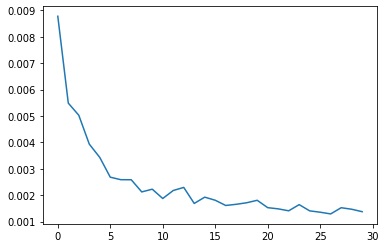

In [54]:
plt.plot(model5.history.history['loss'])
plt.show

In [55]:
MSE5 = []
l_RMSE5 = []
l_MAE5 = []

for y in range(10):
    mse = mean_squared_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list5[y]))
    MSE5.append(mse)
    l_RMSE5.append(math.sqrt(mse))
    l_MAE5.append(mean_absolute_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(pred_list5[y])))
    
    print('MSE : ', MSE5[y], '\nRMSE : ', l_RMSE5[y], '\nMAE : ', l_MAE5[y]) 

MSE :  247.88045380140667 
RMSE :  15.744219694904116 
MAE :  9.355146731755124
MSE :  215.81468326774655 
RMSE :  14.690632500602094 
MAE :  7.072762882614596
MSE :  223.68979693283634 
RMSE :  14.956262799671459 
MAE :  7.615444883707778
MSE :  229.48863429478607 
RMSE :  15.148882278728886 
MAE :  8.825251232188625
MSE :  226.79558022186242 
RMSE :  15.05973373675187 
MAE :  7.584462413534758
MSE :  228.4823106691724 
RMSE :  15.115631335447832 
MAE :  9.308909589631703
MSE :  272.1793275481115 
RMSE :  16.49785827154881 
MAE :  11.096843718193977
MSE :  225.62361582850005 
RMSE :  15.020772810627955 
MAE :  7.744810830773149
MSE :  235.6100019378253 
RMSE :  15.34959289159896 
MAE :  8.031777390870023
MSE :  233.45663554851976 
RMSE :  15.279287795853566 
MAE :  7.850703849470372


In [56]:
npred_list5 = []

for j in range(len(pred_list5[0])):
    npred_list5.append([np.mean([pred_list5[0][j], pred_list5[1][j], pred_list5[2][j], 
                                pred_list5[3][j], pred_list5[4][j], pred_list5[5][j],
                                pred_list5[6][j], pred_list5[7][j], pred_list5[8][j],
                                pred_list5[9][j]])])
    
npred_list5 = np.array(npred_list5)

In [57]:
trainPredict = model1.predict(X_train_t)
trainPredict = scaler.inverse_transform(trainPredict) 

testPredict = scaler.inverse_transform(npred_list5)
Ydata = scaler.inverse_transform(y_test)

testPredict_df = pd.DataFrame(testPredict, columns=['price'], index=y_test.index)
testPredict_df.head()

,price
Date,
2017-08-06,1419.275635
2017-08-07,1419.369019
2017-08-08,1419.746338
2017-08-09,1420.408813
2017-08-10,1421.209839


In [58]:
Ydata_df = pd.DataFrame(Ydata, columns=['price'], index=y_test.index)
Ydata_df.head()

,price
Date,
2017-08-06,1421.09
2017-08-07,1421.84
2017-08-08,1422.82
2017-08-09,1423.53
2017-08-10,1424.54


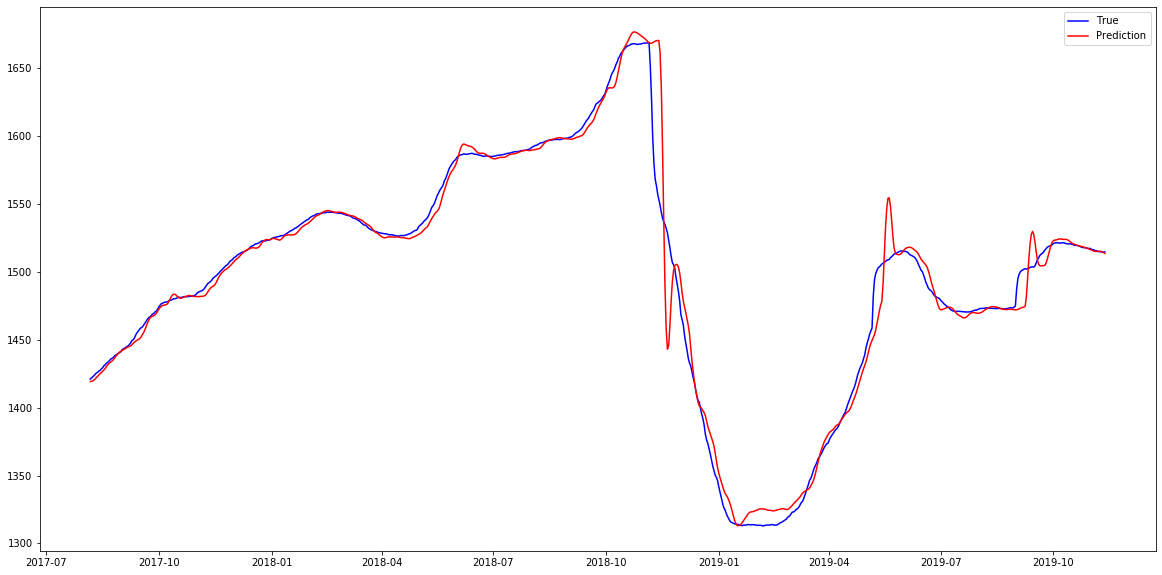

In [59]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata_df, label='True', color = 'Blue')
ax.plot(testPredict_df, label='Prediction', color='Red')
ax.legend()
plt.show()

## 모델 합치기

* 앞의 5개 모델의 y_pred 결과의 평균을 통해 예측

In [60]:
import math

In [61]:
ypred = []

for y in range(10):
    new = []
    for i in range(len(pred_list1[0])):
        new.append([np.mean([pred_list1[y][i], pred_list2[y][i], pred_list3[y][i], pred_list4[y][i], pred_list5[y][i]])])
    ypred.append(new)

In [62]:
y= []

for i in range(len(ypred[0])):
    y.append(np.mean([ypred[0][i], ypred[1][i], ypred[2][i], ypred[3][i], ypred[4][i], ypred[5][i], ypred[6][i], ypred[7][i],
                     ypred[8][i], ypred[9][i]]))

new_ypred = []

for i in range(len(y)):
    new_ypred.append([y[i]])

In [63]:
mse = mean_squared_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(new_ypred))
RMSE = math.sqrt(mse)
ensembel_mse = mse
ensembel_mse

MAE = mean_absolute_error(scaler.inverse_transform(y_test_values), scaler.inverse_transform(new_ypred))
print('MSE : ', ensembel_mse, '\nRMSE : ', RMSE, '\nMAE : ', MAE) 

MSE :  190.95323454443073 
RMSE :  13.818582942705476 
MAE :  6.362862304918176


In [64]:
trainPredict = model1.predict(X_train_t)
trainPredict = scaler.inverse_transform(trainPredict) 

testPredict = scaler.inverse_transform(new_ypred)
Ydata = scaler.inverse_transform(y_test)

In [65]:
testPredict_df = pd.DataFrame(testPredict, columns=['price'], index=y_test.index)
testPredict_df.head()

Ydata_df = pd.DataFrame(Ydata, columns=['price'], index=y_test.index)
Ydata_df.head()

,price
Date,
2017-08-06,1421.09
2017-08-07,1421.84
2017-08-08,1422.82
2017-08-09,1423.53
2017-08-10,1424.54


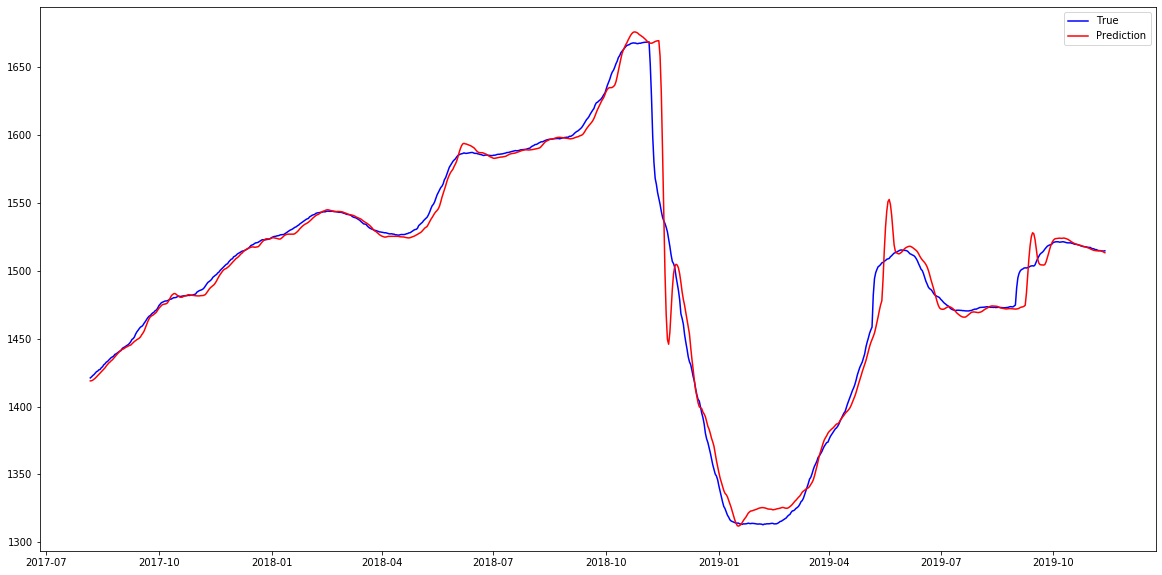

In [66]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata_df, label='True', color = 'Blue')
ax.plot(testPredict_df, label='Prediction', color='Red')
ax.legend()
plt.show()

## 최종 MSE 비교

In [67]:
print("MODEL1 MSE : ", np.mean(MSE1))
print("MODEL2 MSE : ", np.mean(MSE2))
print("MODEL3 MSE : ", np.mean(MSE3))
print("MODEL4 MSE : ", np.mean(MSE4))
print("MODEL5 MSE : ", np.mean(MSE5))
print("Ensemble MODEL MSE : ", ensembel_mse)

MODEL1 MSE :  248.43916592513045
MODEL2 MSE :  266.2885957871571
MODEL3 MSE :  302.75508458952
MODEL4 MSE :  255.75728192049996
MODEL5 MSE :  233.90210400507672
Ensemble MODEL MSE :  190.95323454443073


In [68]:
print("MODEL1 RMSE : ", np.mean(l_RMSE1))
print("MODEL2 RMSE : ", np.mean(l_RMSE2))
print("MODEL3 RMSE : ", np.mean(l_RMSE3))
print("MODEL4 RMSE : ", np.mean(l_RMSE4))
print("MODEL5 RMSE : ", np.mean(l_RMSE5))
print("Ensemble MODEL RMSE : ", RMSE)

MODEL1 RMSE :  15.703700046041543
MODEL2 RMSE :  16.08573473866599
MODEL3 RMSE :  17.21258606947536
MODEL4 RMSE :  15.294638687286916
MODEL5 RMSE :  15.286287411573557
Ensemble MODEL RMSE :  13.818582942705476


In [69]:
print("MODEL1 MAE : ", np.mean(l_MAE1))
print("MODEL2 MAE : ", np.mean(l_MAE2))
print("MODEL3 MAE : ", np.mean(l_MAE3))
print("MODEL4 MAE : ", np.mean(l_MAE4))
print("MODEL5 MAE : ", np.mean(l_MAE5))
print("Ensemble MODEL MAE : ", MAE)

MODEL1 MAE :  9.698268592383517
MODEL2 MAE :  10.467056412681881
MODEL3 MAE :  10.577599090465734
MODEL4 MAE :  9.101417630663823
MODEL5 MAE :  8.44861135227401
Ensemble MODEL MAE :  6.362862304918176


In [70]:
Checklist = {'MODEL': ["MODEL1", "MODEL2", "MODEL3", "MODEL4", "MODEL5", "Ensemble MODEL"],
      'MSE' : [np.mean(MSE1), np.mean(MSE2), np.mean(MSE3), np.mean(MSE4), np.mean(MSE5), ensembel_mse],
      'RMSE' : [np.mean(l_RMSE1), np.mean(l_RMSE2), np.mean(l_RMSE3), np.mean(l_RMSE4), np.mean(l_RMSE5), RMSE],
            'MAE' : [np.mean(l_MAE1), np.mean(l_MAE2), np.mean(l_MAE3), np.mean(l_MAE4), np.mean(l_MAE5), MAE]}

df_Checklist = pd.DataFrame(Checklist)
df_Checklist

df_Checklist.sort_values(["MSE"], ascending=[True])

,MODEL,MSE,RMSE,MAE
5,Ensemble MODEL,190.953235,13.818583,6.362862
4,MODEL5,233.902104,15.286287,8.448611
0,MODEL1,248.439166,15.703700,9.698269
3,MODEL4,255.757282,15.294639,9.101418
1,MODEL2,266.288596,16.085735,10.467056
2,MODEL3,302.755085,17.212586,10.577599


In [71]:
df_Checklist.sort_values(["RMSE"], ascending=[True])

,MODEL,MSE,RMSE,MAE
5,Ensemble MODEL,190.953235,13.818583,6.362862
4,MODEL5,233.902104,15.286287,8.448611
3,MODEL4,255.757282,15.294639,9.101418
0,MODEL1,248.439166,15.703700,9.698269
1,MODEL2,266.288596,16.085735,10.467056
2,MODEL3,302.755085,17.212586,10.577599


In [72]:
df_Checklist.sort_values(["MAE"], ascending=[True])

,MODEL,MSE,RMSE,MAE
5,Ensemble MODEL,190.953235,13.818583,6.362862
4,MODEL5,233.902104,15.286287,8.448611
3,MODEL4,255.757282,15.294639,9.101418
0,MODEL1,248.439166,15.703700,9.698269
1,MODEL2,266.288596,16.085735,10.467056
2,MODEL3,302.755085,17.212586,10.577599
